# Resonances of a 2d dumbbell

**by M. Wess, 2024**

*This Notebook is part of the `td_evp` [documentation](https://markuswess.github.io/td_evp) on the implementation of time-domain methods for resonance problems in [NGSolve](https://ngsolve.org).*

## Introduction

This notebook is designed to present an implementation of the algorithm for solving resonance problems presented in 

* [[NW24a]](https://markuswess.github.io/td_evp/intro.html#id2) Lothar Nannen and Markus Wess. *A krylov eigenvalue solver based on filtered time domain solutions.* 2024. [arXiv:2402.08515](https://arxiv.org/abs/2402.08515).

In particular, we solve the two dimensional problems from Section 3.1.

## Implementation

We start bei doing the necessary imports

In [16]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *

import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as pl
import time as ti
%matplotlib notebook
from scipy.special import jn_zeros, jnjnp_zeros,jnp_zeros

### The filtered operator

In [17]:
class FilteredC(BaseMatrix):
    def __init__(self,mata,matm_inv,tau,weights,freedofs=None):
        super().__init__()
        self.dt = tau
        self.weights = weights
        self.nsteps = len(weights)
        
        self.mata = mata
        self.matm_inv = matm_inv
        
        self.freedofs=freedofs
        
        
        self.vecu = self.mata.CreateColVector()
        self.tmpvec1 = self.mata.CreateColVector()
        self.tmpvec2 = self.mata.CreateColVector()


    def CreateColVector(self):
        return self.mata.CreateColVector()
    
    def Shape(self):
        return self.mata.shape
    def CreateVector(self,col):
        return self.mata.CreateVector(col)
    
    def Mult(self,rhs,out):
        with TaskManager():
            self.vecu.data = rhs
            tau = self.dt
            out.data = tau*weights[0]*self.vecu
            t = 0
            
            unew = self.tmpvec1
            uold = self.tmpvec2
            uold.data = self.vecu
            
            with TaskManager():
                for i in range(1,self.nsteps):
                    t += tau       
                    print("\r time = {}, step = {}".format(t,i),end="")

                    unew.data = 2*self.vecu - uold 
                    unew.data -= tau**2 * self.matm_inv@self.mata * self.vecu
                    if self.freedofs:
                        unew.data[~self.freedofs] = 0.
                    uold.data = self.vecu
                    self.vecu.data = unew.data

                    out.data += tau*weights[i]*self.vecu

### Geometry and mesh

In [18]:
r_l = 1.5
r_r = 0.15
d = 0.03
w = 0.03


circ_left = Circle( (-r_l-w,0), r_l).Face()
circ_right = Circle( (r_r+w,0), r_r).Face()
handle = MoveTo(-r_l,-d).Rectangle(r_l+r_r,2*d).Face()

dumbbell = circ_left+handle+circ_right
geo = OCCGeometry(dumbbell,dim=2)
Draw(dumbbell);

maxh = 2*d
mesh = Mesh(geo.GenerateMesh(maxh = maxh))
mesh.Curve(2)
Draw(mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [19]:
order = 2
fes = H1LumpingFESpace(mesh,order=order)
print(fes.ndof)
u,v = fes.TnT()
mass = BilinearForm(u*v*dx(intrules=fes.GetIntegrationRules()),diagonal=True).Assemble().mat
stiffness = BilinearForm(grad(u)*grad(v)*dx).Assemble().mat
massinv = mass.Inverse()

14613


### Determine time step by power iteration

In [20]:
tol = 1e-4
tmpv = stiffness.CreateVector()
tmpv2 = stiffness.CreateVector()
tmpv.SetRandom()
tmpv /= tmpv.Norm()
mus = [1]
for i in range(500):
    #print("i = {}".format(i))
    tmpv2.data = tmpv
    tmpv.data = massinv@stiffness*tmpv2
    mu = InnerProduct(tmpv2,tmpv)/InnerProduct(tmpv2,tmpv2)
    tmpv /= tmpv.Norm()
    mus.append(mu)
    if mus[-1]/mus[-2]<1+tol:
        break
        
lammax = mus[-1]*(1+tol*200)
print("estimated largest eigenvalue: ",lammax)
tau = np.sqrt(4/lammax)
print("by power iteration stable for tau = {}".format(tau))


estimated largest eigenvalue:  49208.07149039992
by power iteration stable for tau = 0.009015956822034847


### Define and plot filter function

<IPython.core.display.Javascript object>


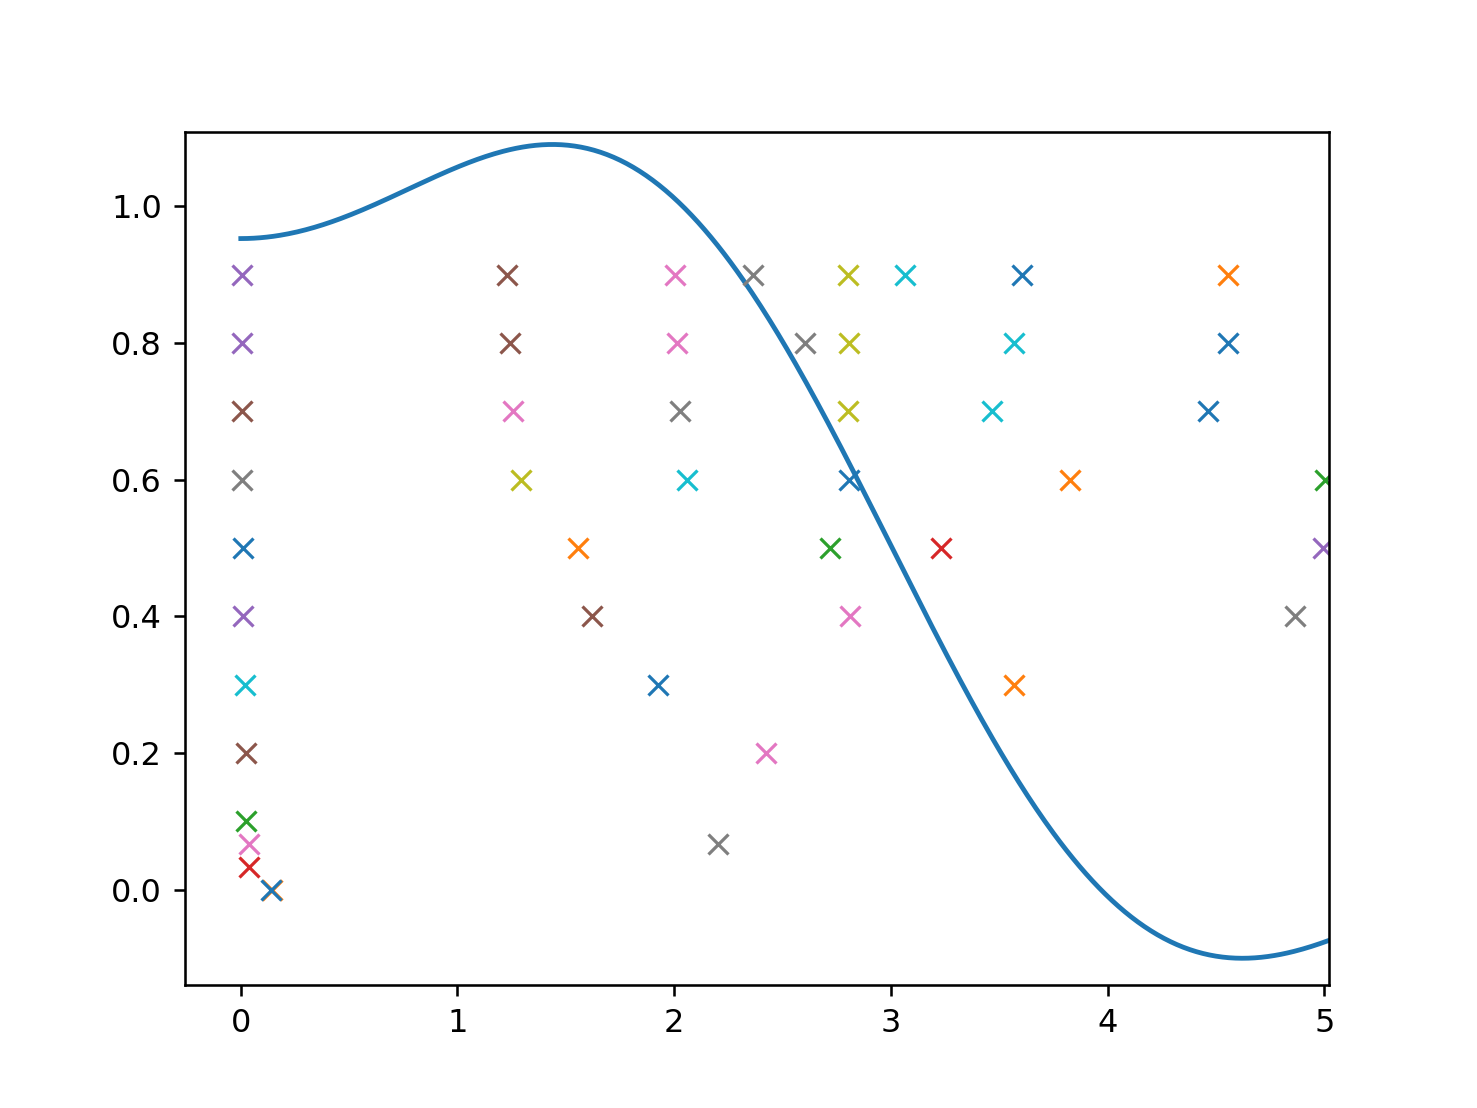

In [25]:
w_min = 0
w_max = 3

L = 200
endT = L*tau

weightf = lambda t: 4/np.pi*np.cos((w_max+w_min)/2*t)*(w_max-w_min)/2*np.sinc((w_max-w_min)/2*t/np.pi)

weights = weightf(tau*np.arange(L))


def beta(omega):
    if np.isscalar(omega):
        q = 1
    else:
        q = np.ones(omega.shape)
    
    q_old = q
    out = tau*weights[0]*q
    for alpha in weights[1:]:
        q_new = 2*q-tau**2*omega**2*q-q_old
        q_old = q
        q = q_new
        out += tau*alpha*q
    return out

omegas = np.arange(0,20,0.01)

betas = beta(omegas)
pl.plot(omegas,betas);

### It remains to start the Krylov loop

<IPython.core.display.Javascript object>


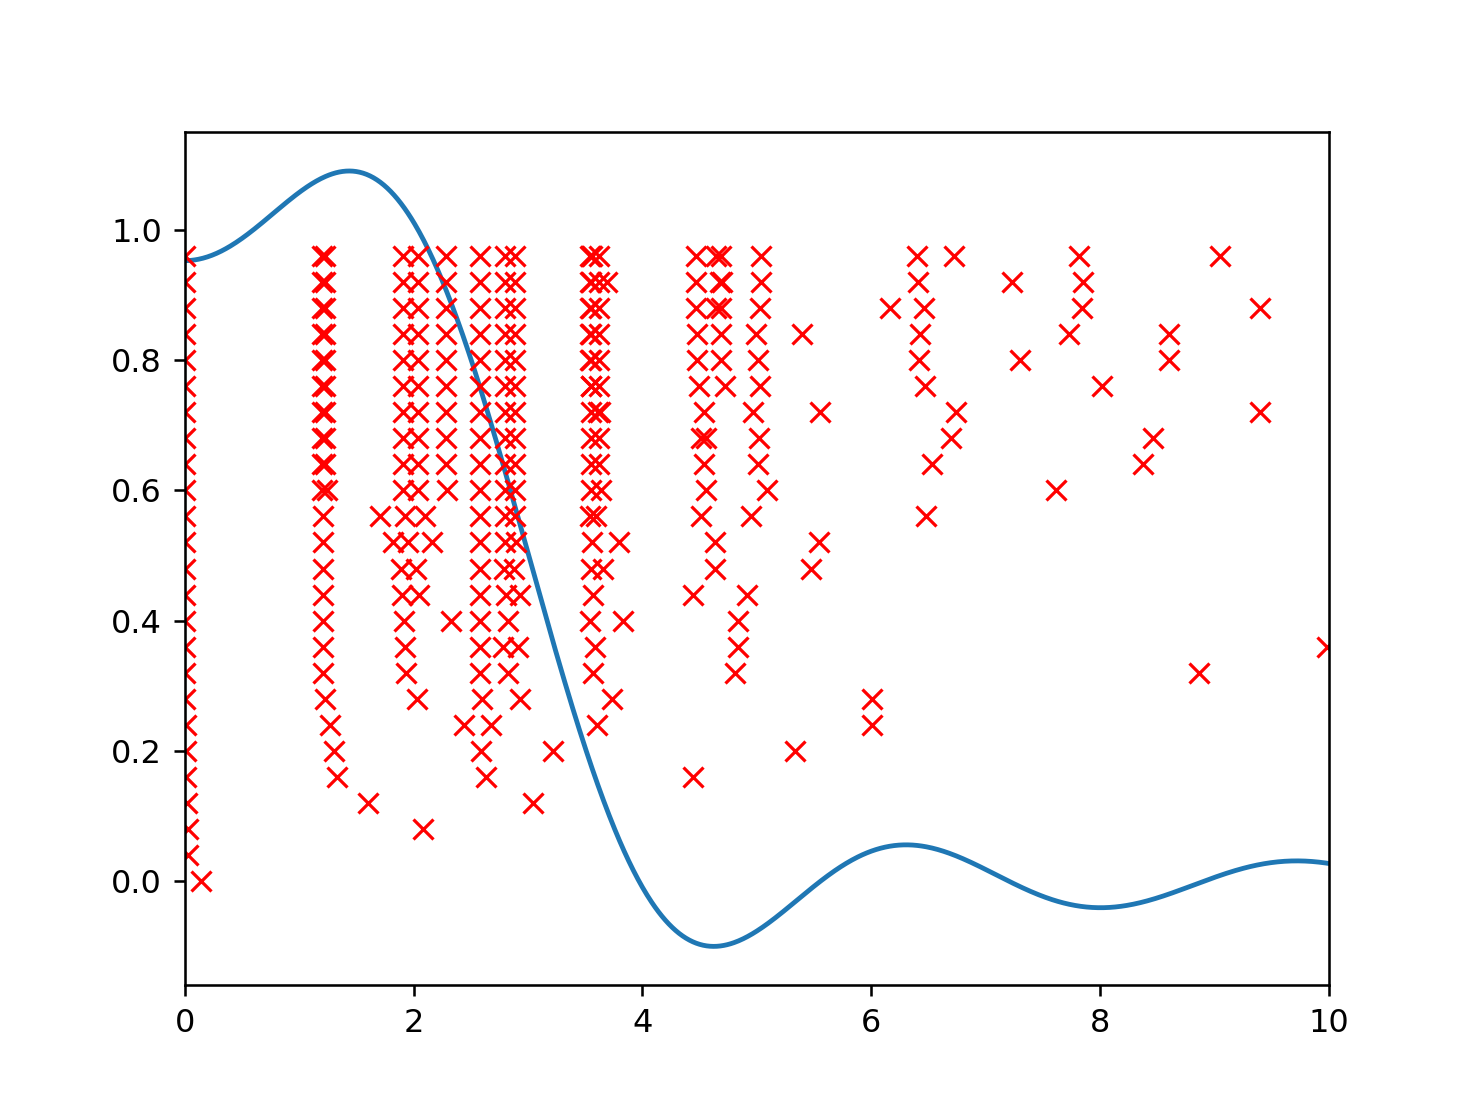


 Krylowstep = 0
 time = 1.7941754075849399, step = 199
 Krylowstep = 1
 time = 1.7941754075849399, step = 199
 Krylowstep = 2
 time = 1.7941754075849399, step = 199
 Krylowstep = 3
 time = 1.7941754075849399, step = 199
 Krylowstep = 4
 time = 1.7941754075849399, step = 199
 Krylowstep = 5
 time = 1.7941754075849399, step = 199
 Krylowstep = 6
 time = 1.7941754075849399, step = 199
 Krylowstep = 7
 time = 1.7941754075849399, step = 199
 Krylowstep = 8
 time = 1.7941754075849399, step = 199
 Krylowstep = 9
 time = 1.7941754075849399, step = 199
 Krylowstep = 10
 time = 1.7941754075849399, step = 199
 Krylowstep = 11
 time = 1.7941754075849399, step = 199
 Krylowstep = 12
 time = 1.7941754075849399, step = 199
 Krylowstep = 13
 time = 1.7941754075849399, step = 199
 Krylowstep = 14
 time = 1.7941754075849399, step = 199
 Krylowstep = 15
 time = 1.7941754075849399, step = 199
 Krylowstep = 16
 time = 1.7941754075849399, step = 199
 Krylowstep = 17
 time = 1.7941754075849399, step = 199
 

In [33]:

maxsteps = 25


C = FilteredC(stiffness,massinv,tau,weights)

now = ti.time()


errsmin = []
resmin = []

tol = 1e-6
solveevery = 1

tmpvec = mass.CreateVector()
vecs = MultiVector(tmpvec,0)

tmpvec.SetRandom()
tmpvec.data = 1/tmpvec.Norm()*tmpvec

vecs.Append(tmpvec)


pl.figure()
pl.plot(omegas,betas);
pl.xlim((0,10))
for i in range(maxsteps):
    print("\n Krylowstep = {}".format(i))

    tmpvec.data = C*vecs[-1]
    vecs.AppendOrthogonalize(tmpvec)
    
    if i%solveevery == 0:
        tvecs = MultiVector(tmpvec,len(vecs))
        tvecs.data = stiffness*vecs
        tvecs2 = MultiVector(tmpvec,len(vecs))
        tvecs2.data = mass*vecs

        matm_proj = InnerProduct(tvecs2,vecs)
        mats_proj = InnerProduct(tvecs,vecs)
        lam,v = spl.eigh(mats_proj.NumPy(),matm_proj.NumPy())

        lam = np.sqrt(np.abs(lam))
        for li in lam:
            pl.plot(li.real,1/maxsteps*i,'xr')
        




In [34]:
eigf = (vecs*Matrix(v.real)).Evaluate()

gfu = GridFunction(fes)

for i in range(1,5):
    gfu.vec.data = eigf[i]
    Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…